## Imports and Load Model

In [1]:
import matplotlib.pyplot as plt
import keras
import h5py 
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.backend import tf as ktf

import sys

MODELS_DIR ="./"
LOAD_MODEL = True
if LOAD_MODEL :
    model = load_model(MODELS_DIR + 'vgg_16_256_64.h5')

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Helper Functions

In [2]:
import cv2

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_cars(img, cars, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for c in cars:
        bbox = c.get_filtered_win()
        #print (bbox)
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
        cv2.rectangle(imcopy, tuple(bbox[0]), (min(bbox[1][0], bbox[0][0] + 75), bbox[0][1] + 25), color, -1)
        cv2.putText(imcopy, 
                    "Car " + str(c.carID) , 
                    (bbox[0][0] + 5, bbox[0][1] + 15), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, 
                    (255,255,255),
                    2)
        
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Malisiewicz et al.
# From: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression_fast(boxes_in, overlapThresh):
    
    
    
  # if there are no boxes, return an empty list
  if len(boxes_in) == 0:
    return []
  boxes = np.array([(b[0][0], b[0][1], b[1][0], b[1][1]) for b in boxes_in])
 


    
  # if the bounding boxes integers, convert them to floats --
  # this is important since we'll be doing a bunch of divisions
  if boxes.dtype.kind == "i":
    boxes = boxes.astype("float")
 
  # initialize the list of picked indexes  
  pick = []
 
  # grab the coordinates of the bounding boxes
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]
 
  # compute the area of the bounding boxes and sort the bounding
  # boxes by the bottom-right y-coordinate of the bounding box
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
 
  # keep looping while some indexes still remain in the indexes
  # list
  while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
 
    # find the largest (x, y) coordinates for the start of
    # the bounding box and the smallest (x, y) coordinates
    # for the end of the bounding box
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
    # compute the width and height of the bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
 
    # compute the ratio of overlap
    overlap = (w * h) / area[idxs[:last]]
 
    # delete all indexes from the index list that have
    idxs = np.delete(idxs, np.concatenate(([last],
      np.where(overlap > overlapThresh)[0])))
 
  # return only the bounding boxes that were picked using the
  # integer data type

  out_boxes = []
  for i in pick:
    out_boxes.append(boxes_in[i])
  return out_boxes




## Vehicle Detection Tracking and Filtering

In [6]:
from scipy.ndimage.filters import gaussian_filter1d as gaussian

class Filter:
    ''' helper class that implements basic averaging filter
        could be extended to provided more advanced filters, 
        e.g.,weighted average or gaussian'''
    def __init__(self, winsize = 10, axis = 0):
        self.winsize = winsize
        # FIFO queue
        self.filter_queue = []
        self.axis = axis
        
        
    def add_value(self, value):
        if len(self.filter_queue) >= self.winsize:
            # remove last element
            del self.filter_queue[-1]
        self.filter_queue.insert(0, value)
        
    def get_value(self):
        '''returns average of values in the queue'''
        q = np.array(self.filter_queue)
        return np.array(np.mean(q, axis = self.axis), dtype='int64')

      
    
    def has_value(self):
        return len(self.filter_queue) > 0
    
class GaussianFilter(Filter):
    '''Same as Filter but with a Gaussian 1D filter, which should react a bit quicker'''
    def get_value(self):
        q = np.array(self.filter_queue)
        f =  gaussian(q, 4.0, axis = 1)
        print (q, f)

        return f
        

class Car:
    carID = 0
    def __init__(self, initial_window):
        self.filter = Filter(winsize = 6)
        self.filter.add_value(np.float32(initial_window))
        self.max_lifespan = 8
        self.lifespan = self.max_lifespan
        Car.carID += 1
        
    def get_filtered_win(self):
        return np.int32(self.filter.get_value())
    
    def get_dist(self, window):
        ''' gets distance from current window to input window
            used to find corresponding windows in subsequent detections 
        '''
        mwin = self.get_filtered_win()
        # subtract windows from each other and return abs sum of result
        return np.abs(np.sum(mwin - window))
    
    def update_window(self, window):
        ''' updates window filter '''
        self.filter.add_value(np.float32(window))
        # preserve lifespan, as it has been updated
        self.lifespan = self.max_lifespan
    
    @staticmethod
    def find_corresponding(cars, window):
        ''' attempts to find a match with previously detected car '''
        if len(cars) == 0:
            return None
        
        diffs = [c.get_dist(window) for c in cars]
        min_car_idx = np.argmin(diffs)
        min_diff = diffs[min_car_idx]
        min_car = cars[min_car_idx]
        
        #print ("Diffs", diffs)
        #print ("minimum diff", min_diff, "carID", min_car.carID , end=" ")
        
        if min_diff <= 250:
            #print (min_car.carID, "--> match!")
            return min_car
        else:
            return None
        
    @staticmethod
    def update_cars(cars):
        '''subtracts 1 from lifespan of cars, then filters out those that are at 0, i.e., 
           haven't been detected in 2 frames '''
        if len(cars) > 0:
            for c in cars:
                c.lifespan -= 1
            remove_list = []
            for c in cars:
                if c.lifespan == 0:
                    remove_list.append(c)
            for c in remove_list:
                cars.remove(c)
            
    
    
        
        
        
        

## Vehicle Detection Pipeline

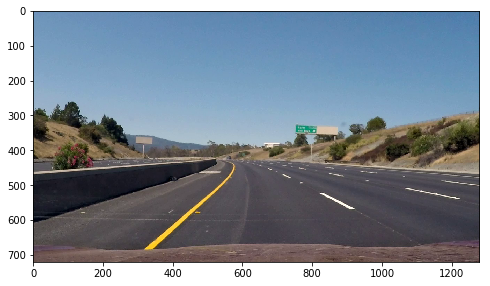

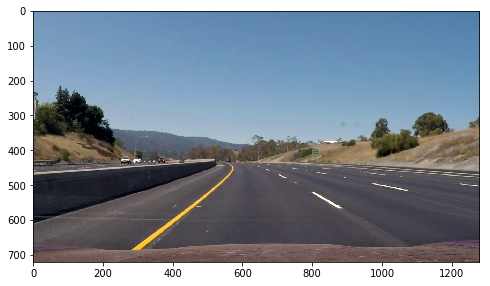

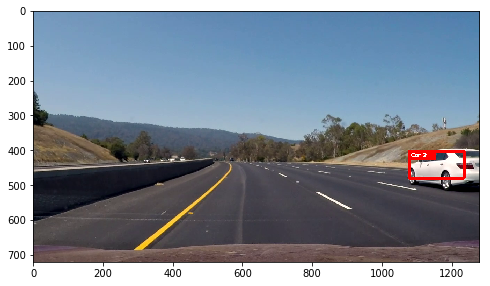

In [ ]:
cars = []
def process_frame(img):
    ''' detects car in input img and annotates these in output image'''
    global cars
    
    # update car list, and remove ones that haven't been seen lately
    Car.update_cars(cars)
    
    M = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #M = img
    #plt.imshow(M)
    #plt.show()
    
    windows_small = slide_window(M, x_start_stop=(538, 968), y_start_stop=(387, 437), 
                    xy_window=(32, 32), xy_overlap=(0.5, 0.5))
    
    windows_med = slide_window(M, x_start_stop=(450, 1280), y_start_stop=(387, 575), 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    
    windows_lg = slide_window(M, x_start_stop=(400, 1280), y_start_stop=(387, 677), 
                    xy_window=(128, 128), xy_overlap=(0.8, 0.8))
    
    windows_xlg = slide_window(M, x_start_stop=(400, 1280), y_start_stop=(387, 677), 
                    xy_window=(196, 196), xy_overlap=(0.7, 0.7))
    
    
    
    all_windows = windows_small + windows_med + windows_lg + windows_xlg
    
    #print (len(windows_small), len(windows_med), len(windows_lg))
    #print (len(windows))
    
    
    
    #print ("Nr. of windows", len(windows_small), len(windows_med), len(windows_lg), len(windows))
                       
    #window_img = draw_boxes(M, windows_small, color=(0, 0, 255), thick=6)   
    #window_img = draw_boxes(window_img, windows_med, color=(0, 255, 255), thick=6)
    #window_img = draw_boxes(window_img, windows_lg, color=(255, 0, 255), thick=6)
    #plt.imshow(window_img)
    #plt.show()
    
    
    
    crops = []
    
   
    crops_small = np.int32([M[c[0][1]:c[1][1], c[0][0]:c[1][0]] for c in windows_small])
    crops_med = np.int32([M[c[0][1]:c[1][1], c[0][0]:c[1][0]] for c in windows_med])
    crops_lg = np.int32([M[c[0][1]:c[1][1], c[0][0]:c[1][0]] for c in windows_lg])
    crops_xlg = np.int32([M[c[0][1]:c[1][1], c[0][0]:c[1][0]] for c in windows_xlg])
    
    
    
    res_small = list(model.predict(crops_small))
    res_med = list(model.predict(crops_med))
    res_lg = list(model.predict(crops_lg))
    res_xlg = list(model.predict(crops_xlg))
    
    res = res_small + res_med + res_lg
    
    
    
    
    window_img = np.array(M)
    
    heat = np.zeros_like(window_img[:,:,0]).astype(np.float)

    
    #print (res)
    boxes = []
    for w, r in zip(all_windows, res):
        if r[1] > 0.99:
            boxes.append(w)
           
            
    
    #if len(cars) > 0:
        #window_img = draw_windows(boxes, cars, color=(0,0,255), thick = 4)  
    heat = add_heat(heat, boxes)
     
    thresh = np.array(heat)
    
    thresh = apply_threshold(thresh, 11)
    
   

    ret, thresh = cv2.threshold(thresh, 0,255, cv2.THRESH_BINARY)
    
    
    thresh[thresh > 0] = 1
    thresh = np.uint8(thresh)
    #print (thresh.shape, thresh.dtype)
        
    n, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S)
    
    #print (n)
    #print(labels)
    #print (stats)
    
    car_boxes = []
    
    n_cars = 0
    for x0,y0,w,h,a in stats[1:]:
        if a > 6000:
            #print (a)
            car_boxes.append([(x0,y0),(x0+w,y0+h)])
            
    for b in car_boxes:
            #print ("Car detected:", b)
            corr = Car.find_corresponding(cars, b)
            if corr != None:
                corr.update_window(b)
            else:
                cars.append(Car(b))

    car_boxes_img = np.array(M)
    
    if len(cars) >0:
        car_boxes_img = draw_cars(car_boxes_img, 
                               cars, 
                               color=(255,0,0), 
                               thick=8)
    return car_boxes_img


##### run the video pipeline

VIDEO_FILE='project_video.mp4'
VIDEO_W = 1280
VIDEO_H = 720



import cv2

cap = cv2.VideoCapture(VIDEO_FILE)

# set codec to mpeg4
fourcc = cv2.VideoWriter_fourcc(*'H264')
out = out = cv2.VideoWriter('car_detect_output.mp4',fourcc, 30.0, (VIDEO_W, VIDEO_H))

frame_ctr = 0
while True:
    ret,frame = cap.read()
    if ret == False:
        break
    
    car_detect_frame = process_frame(frame) 
    
    
    print(frame_ctr, end = "\r")
    if frame_ctr % 100 == 0:
        plt.rcParams['figure.figsize'] = (8,5)
        plt.imshow(car_detect_frame)
        plt.show()
    frame_ctr += 1
    out.write(cv2.cvtColor(car_detect_frame, cv2.COLOR_RGB2BGR))
    

print ("Processed", frame_ctr, "Frames")

out.release()
cap.release()

### video playback
from IPython.display import HTML

HTML('''
<video width="640" height="480" controls>
  <source src="car_detect_output.mp4" type="video/mp4">
</video>''')

In [8]:
HTML('''
<video width="640" height="480" controls>
  <source src="car_detect_output.mp4" type="video/mp4">
</video>''')